In [20]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from pathlib import Path

### import jupyter notebook of Practical C in order to use and not redefine useful functions used there
import import_ipynb
from practicalMixGaussC import multivariate_gaussian_probability_vectorized
from practicalMixGaussC import log_likelihood_vectorized
from practicalMixGaussC import E_step_vectorized
from practicalMixGaussC import M_step_vectorized

In [21]:
### path where apples images and masks are stored
train_images_path = 'apples/apples'

In [22]:
def load_filenames(path):
    ### find all apple images and masks
    included_extensions = ['jpg','jpeg','png']
    file_names = [fn for fn in os.listdir(path) if any(fn.endswith(ext) for ext in included_extensions)]
    return file_names

In [23]:
file_names = load_filenames(train_images_path)

In [24]:
print(file_names)

['apple_3.jpg', 'apple_2_mask.png', 'apple_3_mask.png', 'apple_1.jpg', 'apple_2.jpg', 'apple_1_mask.png']


In [25]:
### create the whole path of each file
files = []
for f in file_names:
    path_of_file = train_images_path + '/' + f
    files.append(path_of_file)

In [26]:
## sort the files by name
files = sorted(files)

In [27]:
print(files)

['apples/apples/apple_1.jpg', 'apples/apples/apple_1_mask.png', 'apples/apples/apple_2.jpg', 'apples/apples/apple_2_mask.png', 'apples/apples/apple_3.jpg', 'apples/apples/apple_3_mask.png']


In [28]:
## create 
pairs = []
i = 0
while i < (len(files) - 1):
    pairs.append((files[i],files[i+1]))
    i += 2
print(pairs)

[('apples/apples/apple_1.jpg', 'apples/apples/apple_1_mask.png'), ('apples/apples/apple_2.jpg', 'apples/apples/apple_2_mask.png'), ('apples/apples/apple_3.jpg', 'apples/apples/apple_3_mask.png')]


In [29]:
def normalize_image(image):
    return image / 255

In [30]:
def create_binary_mask(mask):

    ## Read ground the ground truth mask
    ## Create a binary matrix representation of the mask we read.
    
    height = np.array(mask).shape[0]
    width = np.array(mask).shape[1]
    
    ## the third dimension of the third dimension of the mask determines if the pixel is apple or non apple pixel 

    binary_mask = np.zeros((height,width))
    for i in range(0,height):
        for j in range(0,width):
            if(mask[i][j][2] != 0):
                binary_mask[i][j] = 1
            else:
                binary_mask[i][j] = 0
                
    return binary_mask

Processing pair of images: ('apples/apples/apple_1.jpg', 'apples/apples/apple_1_mask.png')
Shape of the image is: (640, 480, 3)
Processing pair of images: ('apples/apples/apple_2.jpg', 'apples/apples/apple_2_mask.png')
Shape of the image is: (397, 500, 3)
Processing pair of images: ('apples/apples/apple_3.jpg', 'apples/apples/apple_3_mask.png')
Shape of the image is: (491, 600, 3)


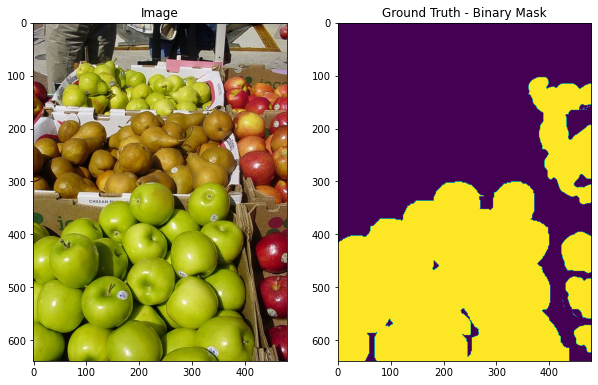

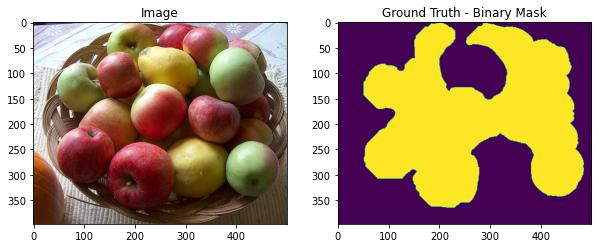

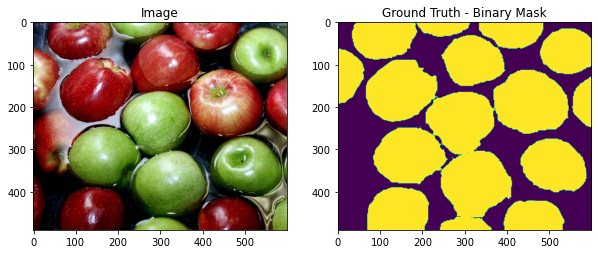

In [31]:
# In these two lists we store the pixels of each class apple/no apple
apple_pixels = []
non_apple_pixels = []

## process in pairs every apple image and its ground tuth mask
for (image,ground_truth) in pairs:
    
    print("Processing pair of images: " + str((image,ground_truth)))
    
    ## read the specific image
    image = plt.imread(image)
    
    print("Shape of the image is: " + str(image.shape))
    
    ## normalise the image, diving by the max value of a pixel in RGB
    ## in this way the max value is set to 1
    image = normalize_image(image)
    
    mask = plt.imread(ground_truth)
    
    ## create a binary mask of 0 and 1 determing which pixels refer to apples and which not
    binary_mask = create_binary_mask(mask)
    
    ## create a list of pixels for each of the two classes apples/mon apples
    ## Based on the image and the mask we read
    for i in range(binary_mask.shape[0]):
        for j in range(binary_mask.shape[1]):
            ## if the respective pixel corresponds to apple class
            if binary_mask[i, j] != 0:
                apple_pixels.append(image[i,j])
            ## if the respective pixels does not correspond to apple class
            else:
                non_apple_pixels.append(image[i,j])
                
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(image)
    ax1.set_title('Image')
    ax2.imshow(binary_mask)
    ax2.set_title('Ground Truth - Binary Mask')
    
plt.show()

In [32]:
### Here we compute the total pixelss we have available for the training
### We calculate also two priors (Apple and Non Apple Prior)

apple_pixels = np.asarray(apple_pixels).T
non_apple_pixels = np.asarray(non_apple_pixels).T

print("Apple Pixels have shape of: " + str(apple_pixels.shape))
print("Non apple Pixels have shape of: " + str(non_apple_pixels.shape))

### total number of pixels apples + non apples
total_pixels = apple_pixels.shape[1] + non_apple_pixels.shape[1]
apple_prior = apple_pixels.shape[1] / total_pixels
non_apple_prior = non_apple_pixels.shape[1] / total_pixels

print("Total pixels: " + str(total_pixels))
print("Apple Prior: " + str(apple_prior))
print("Non Apple Prior: " + str(non_apple_prior))

Apple Pixels have shape of: (3, 429536)
Non apple Pixels have shape of: (3, 370764)
Total pixels: 800300
Apple Prior: 0.5367187304760714
Non Apple Prior: 0.4632812695239285


In [33]:
## calculate mean and covariance
def calculate_mean_and_cov(data):
    mean = np.mean(data, axis=1)
    return (mean,(1 / data.shape[1] * (data - mean[:, None]) @ (data - mean[:, None]).T))

In [34]:
def model_initialization(data,k):
    
    ## number of pixels and number of channels we have 
    nDims, nData = data.shape
    
    ## calculate the mean and the covariance of the data
    mean,cov = calculate_mean_and_cov(data)
    
    init_type = 0
    
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    
    if(init_type==1):
        mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
        mixGaussEst['mean'] = mean[:, None] * (0.5 + np.random.uniform(size=(k)))
        mixGaussEst['cov'] = \
        (2 + 0.4 * np.random.normal(size=(k)))[None, None] * cov[:, :, None] 
    else:
        mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
        mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
        mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
        for cGauss in range(k):
            mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
    
    return mixGaussEst

In [35]:
def plot_likelihood(iterations,likelihood):
    
    plt.plot(iterations, likelihood, color='green', label='Log-Likelihood')
    plt.title('Log Likelihood over iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Log-Likelihood')
    plt.legend()
    plt.show()
    plt.figure()

In [36]:
## define a criteria to deterime when to stop training
## if abs(log_likelihood(i) - log_likelihood(i-1) < 0.001
## if the is minor change on the loglikelihood through 2 consecutive iterations the stop training
## and return the current model
def stop_training_criteria(training_threshhold,log_list,index):
    if(abs(log_list[index] - log_list[index-1]) < training_threshhold):
        return True
    else:
        return False

Here we fit our Gaussian Mixture Model

In [37]:
def GaussianMixtureModel(data,k,training_threshhold):
    
        mixGaussEst = model_initialization(data,k)
    
        ## initialize the responsibilities with zeros
        responsibilities = np.zeros(shape=(k,data.shape[1]))
        
        ## compute the log likelihood for the initial arbitrary configuration of parameters
        log_lkl = log_likelihood_vectorized(data, mixGaussEst)
        
        print("Log likelihood before the first iter is: " + str(log_lkl))


        # Maximum Number of iterations
        ## The training terminates earlier if a training stop criteria we set is satisfied
        max_iterations = 300
        
        iter_list = []
        log_list = []

        for cIter in range(max_iterations):
            
            iter_list.append(cIter)
            
            log_list.append(log_lkl)
            
            ## perform expectation step and update the responsibilities
            responsibilities = E_step_vectorized(responsibilities,mixGaussEst,data)
            
            ## perform maximisation step and update the model parameters based on the new responsibilities
            mixGaussEst = M_step_vectorized(responsibilities,mixGaussEst,data)
            
            log_lkl = log_likelihood_vectorized(data, mixGaussEst)
            
            print("Log likelihood of iter: " + str(cIter) + " is " + str(log_lkl))
            
            if(cIter > 1):
                if(stop_training_criteria(training_threshhold,log_list,cIter) == True):
                    print("Training stoped at iteration: "  + str(cIter) + " with log likelihood: " + str(log_lkl) + " as no further improvement was observed")
                    return mixGaussEst 
            
        plot_likelihood(iter_list,log_list)
            
        return mixGaussEst

In [38]:
training_threshhold = 0.001
Apple_Gaussians = 3
Non_Apple_Gaussians = 3

apple_model = GaussianMixtureModel(apple_pixels,Apple_Gaussians,training_threshhold)
non_apple_model = GaussianMixtureModel(non_apple_pixels,Non_Apple_Gaussians,training_threshhold)

Log likelihood before the first iter is: -3035348.736819331
Log likelihood of iter: 0 is 288377.968559914
Log likelihood of iter: 1 is 299633.784097652
Log likelihood of iter: 2 is 326636.2407877641
Log likelihood of iter: 3 is 370413.23961121426
Log likelihood of iter: 4 is 422308.4725885535
Log likelihood of iter: 5 is 468380.6194350402
Log likelihood of iter: 6 is 500778.3109288147
Log likelihood of iter: 7 is 517752.3718495139
Log likelihood of iter: 8 is 526065.4543955361
Log likelihood of iter: 9 is 530560.0943534572
Log likelihood of iter: 10 is 533362.9831900868
Log likelihood of iter: 11 is 535388.1371197152
Log likelihood of iter: 12 is 537014.7890860613
Log likelihood of iter: 13 is 538428.1461879673
Log likelihood of iter: 14 is 539745.1975794894
Log likelihood of iter: 15 is 541056.6222169086
Log likelihood of iter: 16 is 542445.3533515896
Log likelihood of iter: 17 is 544000.5537883673
Log likelihood of iter: 18 is 545834.4154664162
Log likelihood of iter: 19 is 548108.82

Log likelihood of iter: 65 is 693526.8157911415
Log likelihood of iter: 66 is 693948.2101190186
Log likelihood of iter: 67 is 694315.6310455545
Log likelihood of iter: 68 is 694630.2285037326
Log likelihood of iter: 69 is 694895.6675434161
Log likelihood of iter: 70 is 695117.5482187945
Log likelihood of iter: 71 is 695302.583891924
Log likelihood of iter: 72 is 695457.3532077072
Log likelihood of iter: 73 is 695587.439235109
Log likelihood of iter: 74 is 695697.2215100307
Log likelihood of iter: 75 is 695790.0650534607
Log likelihood of iter: 76 is 695868.6169818876
Log likelihood of iter: 77 is 695935.0275030788
Log likelihood of iter: 78 is 695991.0695665176
Log likelihood of iter: 79 is 696038.2220379093
Log likelihood of iter: 80 is 696077.7508499972
Log likelihood of iter: 81 is 696110.7724191068
Log likelihood of iter: 82 is 696138.2838020542
Log likelihood of iter: 83 is 696161.1681221001
Log likelihood of iter: 84 is 696180.1931655807
Log likelihood of iter: 85 is 696196.01404

In [39]:
def likelihood(data, mixGaussEst):
        result = np.zeros((mixGaussEst['k'],data.shape[1]))
        for k in range(mixGaussEst['k']):
            result[k,:] = mixGaussEst['weight'][k]*multivariate_gaussian_probability_vectorized(data, mixGaussEst['mean'][:, k], mixGaussEst['cov'][:, :, k])
        return np.sum(result, axis=0)

In [40]:
# maybe reform this function

def posterior_mask(image,apple_model,non_apple_model):
    
    width,height,channels = image.shape
    
    reshaped_image = image.reshape(height*width,channels)
       
    ## compute the apple likelihood of each pixel  
    apple_likelihood = likelihood(reshaped_image.T,apple_model).reshape(width,height)
    non_apple_likelihood = likelihood(reshaped_image.T,non_apple_model).reshape(width,height)
    
    ## compute the normalisation constant of the posterior distributio
    normalisation_constant = (apple_likelihood * apple_prior)+ (non_apple_likelihood * non_apple_prior)
        
    ## compute the apple posterior distribution of apple    
    apple_posterior = apple_likelihood * apple_prior / normalisation_constant

    return apple_posterior

In [41]:
def ROC_Curve_Plot(false_positive_rate,true_positive_rate):
    
    plt.plot(false_positive_rate, true_positive_rate, color='red', label='ROC-Curve')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()
    plt.show()
    plt.figure()    

In [48]:
def evaluate(apple_posterior,binary_mask):
    
    ## create a threshhold range
    thresh_hold_range = np.arange(0,1,0.02)
    
    tpr_list = []
    fpr_list = []
    
    for index in range(len(thresh_hold_range)):
        current_threshhold = thresh_hold_range[index]
        
        print("Evaluating for threshhold: " + str(current_threshhold))
        
        true_positive = 0
        true_negative = 0
        false_positive = 0
        false_negative = 0
        
        true_positive_rate = 0
        false_positive_rate = 0
        
        for i in range(apple_posterior.shape[0]):
            for j in range(apple_posterior.shape[1]):
                if((binary_mask[i][j] == 1) and (apple_posterior[i][j] > current_threshhold)):
                    true_positive += 1
                elif ((binary_mask[i][j] == 1) and (apple_posterior[i][j] < current_threshhold)):
                    false_positive += 1
                elif ((binary_mask[i][j] == 0) and (apple_posterior[i][j] < current_threshhold)):
                    true_negative += 1
                elif ((binary_mask[i][j] == 0) and (apple_posterior[i][j] > current_threshhold)):
                    false_negative += 1
                    
        print("Evaluating for threshhold: " + str(current_threshhold) + " tp-tn-fp-fn:  " + str(true_positive) + "-" + str(true_negative) + "-" + str(false_positive) + "-" + str(false_negative))
          
        denom_1 = true_positive + false_negative
        denom_2 = false_positive + true_negative
        
        if(denom_1 == 0):
            true_positive_rate = 0
        else:
            true_positive_rate = true_positive/(denom_1)
            
        if(denom_2 == 0):
            false_positive_rate = 0
        else:
            false_positive_rate = false_positive/(denom_2)
        
        tpr_list.append(true_positive_rate)
        fpr_list.append(false_positive_rate)
        
    ROC_Curve_Plot(fpr_list,tpr_list)

Testing image: testApples/apple_1.jpg
A Mask for this file does not exist!
Testing image: testApples/apple_2.jpg
A Mask for this file exists and is: testApples/apple_2_mask.png
Evaluating for threshhold: 0.0
Evaluating for threshhold: 0.0 tp-tn-fp-fn:  383738-0-0-2616262
Evaluating for threshhold: 0.1
Evaluating for threshhold: 0.1 tp-tn-fp-fn:  381668-464451-2070-2151811
Evaluating for threshhold: 0.2
Evaluating for threshhold: 0.2 tp-tn-fp-fn:  378561-2221240-5177-395022
Evaluating for threshhold: 0.30000000000000004
Evaluating for threshhold: 0.30000000000000004 tp-tn-fp-fn:  373371-2489071-10367-127191
Evaluating for threshhold: 0.4
Evaluating for threshhold: 0.4 tp-tn-fp-fn:  367052-2560677-16686-55585
Evaluating for threshhold: 0.5
Evaluating for threshhold: 0.5 tp-tn-fp-fn:  356282-2580595-27456-35667
Evaluating for threshhold: 0.6000000000000001
Evaluating for threshhold: 0.6000000000000001 tp-tn-fp-fn:  332429-2590922-51309-25340
Evaluating for threshhold: 0.7000000000000001
E

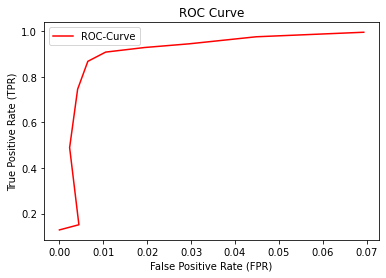

Testing image: testApples/apple_3.jpg
A Mask for this file does not exist!


<Figure size 432x288 with 0 Axes>

In [49]:
num_of_testing_images = 3
testing_directory = 'testApples'

for i in range(0,num_of_testing_images):
    
    image_name = testing_directory + '/' + 'apple_' + str(i+1) + '.jpg'
    mask_name = testing_directory + '/' + 'apple_' + str(i+1) + '_mask.png'
    
    print("Testing image: " + image_name)
    
    maskf = Path(mask_name)
    
    mask_flag = 0
    if maskf.is_file():
        print("A Mask for this file exists and is: " + mask_name)
        mask_flag = 1
    else:
        print("A Mask for this file does not exist!")
      
    ## read the image and normalise it
    img = plt.imread(image_name)
    ## normalize image
    img = normalize_image(img)
    
    apple_posterior = posterior_mask(img,apple_model,non_apple_model)
    
    ## if a ground truth mask exists for that image
    ## evaluate the results using ROC_CURVE
    if(mask_flag == 1):
        ## read the respective mask file
        mask = plt.imread(maskf)
        ## create a binary mask of 0 and 1 determing which pixels refer to apples and which not
        binary_mask = create_binary_mask(mask)
        evaluate(apple_posterior,binary_mask)
  
    #_, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))
    #ax1.imshow(img)
    #ax1.set_title('Image')
    #ax2.imshow(apple_posterior)
    #ax2.set_title('Posterior')
    #plt.show()